# Non i.i.d. data

In machine learning, it is quite common to assume that the data are i.i.d,
meaning that the generative process does not have any memory of past samples
to generate new samples.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">i.i.d is the acronym of "independent and identically distributed"
(as in "independent and identically distributed random variables").</p>
</div>

This assumption is usually violated in time series, where each sample can be
influenced by previous samples (both their feature and target values) in an
inherently ordered sequence.

In this notebook we demonstrate the issues that arise when using the
cross-validation strategies we have presented so far, along with non-i.i.d.
data. For such purpose we load financial
quotations from some energy companies.

In [1]:
import pandas as pd

symbols = {
    "TOT": "Total",
    "XOM": "Exxon",
    "CVX": "Chevron",
    "COP": "ConocoPhillips",
    "VLO": "Valero Energy",
}
template_name = "../datasets/financial-data/{}.csv"

quotes = {}
for symbol in symbols:
    data = pd.read_csv(
        template_name.format(symbol), index_col=0, parse_dates=True
    )
    quotes[symbols[symbol]] = data["open"]
quotes = pd.DataFrame(quotes)

We can start by plotting the different financial quotations.

/home/karansinghthakor/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


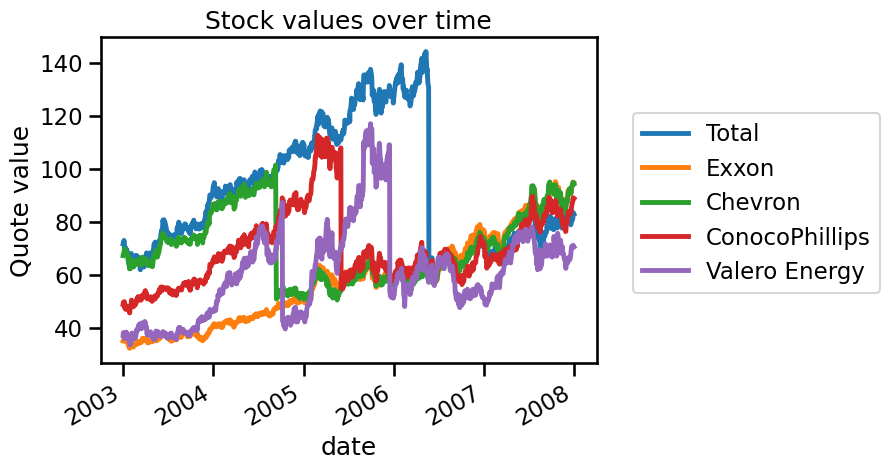

In [2]:
import matplotlib.pyplot as plt

quotes.plot()
plt.ylabel("Quote value")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Stock values over time")

Here, we want to predict the quotation of Chevron using all other energy
companies' quotes. To make explanatory plots, we first use a train-test split
and then we evaluate other cross-validation methods.

In [3]:
data, target = quotes.drop(columns=["Chevron"]), quotes["Chevron"]

We will use a decision tree regressor that we expect to overfit and thus not
generalize to unseen data. We use a `ShuffleSplit` cross-validation to
check the generalization performance of our model.

Let's first define our model

In [4]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor()

And now the cross-validation strategy.

In [5]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(random_state=0)

We then perform the evaluation using the `ShuffleSplit` strategy.

In [6]:
from sklearn.model_selection import cross_val_score

test_score = cross_val_score(regressor, data, target, cv=cv, n_jobs=2)
print(f"The mean R2 is: {test_score.mean():.2f} ± {test_score.std():.2f}")

The mean R2 is: 0.94 ± 0.08


Surprisingly, we get outstanding generalization performance. We will
investigate and find the reason for such good results with a model that is
expected to fail. We previously mentioned that `ShuffleSplit` is a
cross-validation method that iteratively shuffles and splits the data.

We can simplify the
procedure with a single split and plot the prediction. We can use
`train_test_split` for this purpose.

In [7]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, shuffle=True, random_state=0
)

# Shuffling breaks the index order, but we still want it to be time-ordered
data_train.sort_index(ascending=True, inplace=True)
data_test.sort_index(ascending=True, inplace=True)
target_train.sort_index(ascending=True, inplace=True)
target_test.sort_index(ascending=True, inplace=True)

regressor.fit(data_train, target_train)
target_predicted = regressor.predict(data_test)
# Recover the `DatetimeIndex` from `target_test` for correct plotting
target_predicted = pd.Series(target_predicted, index=target_test.index)

Let's check the generalization performance of our model on this split.

In [8]:
from sklearn.metrics import r2_score

test_score = r2_score(target_test, target_predicted)
print(f"The R2 on this single split is: {test_score:.2f}")

The R2 on this single split is: 0.82


Similarly, we obtain good results in terms of $R^2$. We now plot the
training, testing and prediction samples.

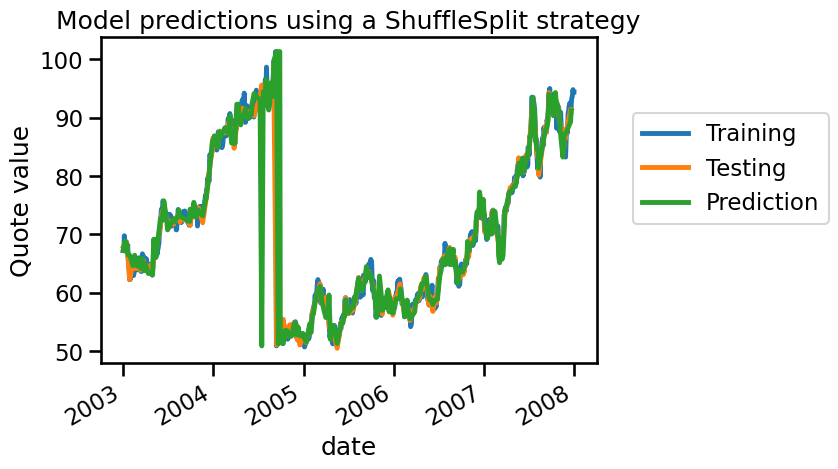

In [9]:
target_train.plot(label="Training")
target_test.plot(label="Testing")
target_predicted.plot(label="Prediction")

plt.ylabel("Quote value")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Model predictions using a ShuffleSplit strategy")

From the plot above, we can see that the training and testing samples are
alternating. This structure effectively evaluates the model’s ability to
interpolate between neighboring data points, rather than its true
generalization ability. As a result, the model’s predictions are close to the
actual values, even if it has not learned anything meaningful from the data.
This is a form of **data leakage**, where the model gains access to future
information (testing data) while training, leading to an over-optimistic
estimate of the generalization performance.

An easy way to verify this is to not shuffle the data during
the split. In this case, we will use the first 75% of the data to train and
the remaining data to test. This way we preserve the time order of the data, and
ensure training on past data and evaluating on future data.

In [10]:
data_train, data_test, target_train, target_test = train_test_split(
    data,
    target,
    shuffle=False,
)
regressor.fit(data_train, target_train)
target_predicted = regressor.predict(data_test)
target_predicted = pd.Series(target_predicted, index=target_test.index)

In [11]:
test_score = r2_score(target_test, target_predicted)
print(f"The R2 on this single split is: {test_score:.2f}")

The R2 on this single split is: -2.22


In this case, we see that our model is not magical anymore. Remember that a
negative $R^2$ means that the regressor performs worse than always predicting
the mean of the target. We can visually check what we are predicting as follows:

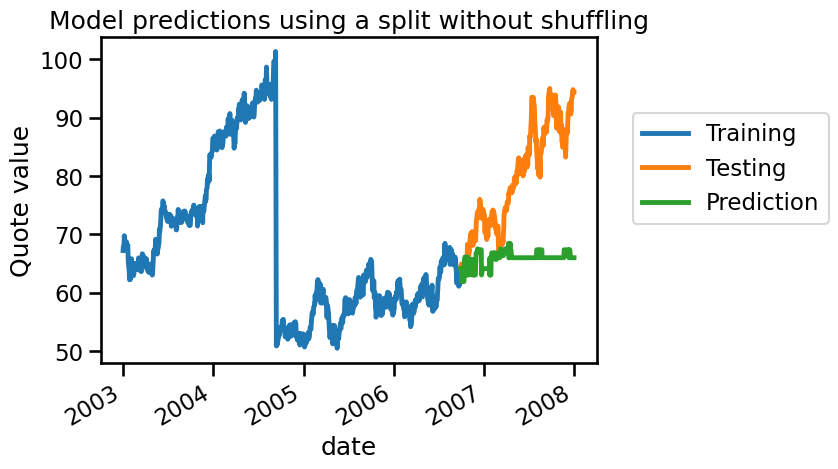

In [12]:
target_train.plot(label="Training")
target_test.plot(label="Testing")
target_predicted.plot(label="Prediction")

plt.ylabel("Quote value")
plt.legend(bbox_to_anchor=(1.05, 0.8), loc="upper left")
_ = plt.title("Model predictions using a split without shuffling")

We see that our model cannot predict anything because it doesn't have samples
around the testing sample. Let's check how we could have made a proper
cross-validation scheme to get a reasonable generalization performance
estimate.

One solution would be to group the samples into time blocks, e.g. by quarter,
and predict each group's information by using information from the other
groups. We can use the `LeaveOneGroupOut` cross-validation for this purpose.

In [13]:
from sklearn.model_selection import LeaveOneGroupOut

groups = quotes.index.to_period("Q")
cv = LeaveOneGroupOut()
test_score = cross_val_score(
    regressor, data, target, cv=cv, groups=groups, n_jobs=2
)
print(f"The mean R2 is: {test_score.mean():.2f} ± {test_score.std():.2f}")

The mean R2 is: -0.90 ± 1.69


In this case, we see that we cannot make good predictions, which is less
surprising than our original results.

Another thing to consider is the actual application of our solution. If our
model is aimed at forecasting (i.e., predicting future data from past data),
we should not use training data that are ulterior to the testing data. In this
case, we can use the `TimeSeriesSplit` cross-validation to enforce this
behaviour.

In [14]:
from sklearn.model_selection import TimeSeriesSplit

cv = TimeSeriesSplit(n_splits=groups.nunique())
test_score = cross_val_score(regressor, data, target, cv=cv, n_jobs=2)
print(f"The mean R2 is: {test_score.mean():.2f} ± {test_score.std():.2f}")

The mean R2 is: -5.45 ± 16.64


In conclusion, it is really important not to carelessly use a
cross-validation strategy which do not respect some assumptions such as having
i.i.d data. It might lead to misleading outcomes, creating the false
impression that a predictive model performs well when it may not be the case
in the intended real-world scenario.

scikit-learn offers useful tools for time-series analysis apart from
`TimeSeriesSplit`, (see for instance the [Time-related feature engineering
example](https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html)
in the documentation), and scikit-learn models can yield even better results
when combined with other specialized libraries.